In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras import layers,models
import tensorflow as tf
from tensorflow import keras

In [7]:
# It will load the image dataset from potato 
# directory and then convert image into soze of 256*256 and then make 
# batches of 32 
from random import shuffle
IAMGE_SIZE = 256
BATCH_SIZE =32

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "potato",
    shuffle=True,
    image_size = (IAMGE_SIZE,IAMGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 2152 files belonging to 3 classes.


In [10]:
# classes of potato images 
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [12]:
# as the dataset is divided into 3 classes with batsize 32 32 images each
len(dataset)

68

In [19]:
for image_batch , label_batch in dataset.take(1):
    # There are 32 images in an batch each of 256 * 256 and rgb of 3
    print(image_batch.shape)
    # print 1 st image 
    #print(image_batch[0])
    print(image_batch[0].numpy())#convert tensor to image
    print(label_batch.numpy())

(32, 256, 256, 3)
[[[138. 134. 149.]
  [136. 132. 147.]
  [135. 131. 146.]
  ...
  [116. 112. 127.]
  [124. 120. 135.]
  [146. 142. 157.]]

 [[139. 135. 150.]
  [137. 133. 148.]
  [135. 131. 146.]
  ...
  [128. 124. 139.]
  [124. 120. 135.]
  [133. 129. 144.]]

 [[140. 136. 151.]
  [138. 134. 149.]
  [136. 132. 147.]
  ...
  [128. 124. 139.]
  [120. 116. 131.]
  [123. 119. 134.]]

 ...

 [[133. 129. 144.]
  [133. 129. 144.]
  [135. 131. 146.]
  ...
  [102.  98. 113.]
  [103.  99. 114.]
  [102.  98. 113.]]

 [[134. 130. 145.]
  [134. 130. 145.]
  [136. 132. 147.]
  ...
  [103.  99. 114.]
  [104. 100. 115.]
  [102.  98. 113.]]

 [[135. 131. 146.]
  [135. 131. 146.]
  [137. 133. 148.]
  ...
  [101.  97. 112.]
  [103.  99. 114.]
  [101.  97. 112.]]]
[1 0 0 1 0 1 2 1 1 1 1 1 1 1 0 1 2 0 0 0 0 1 1 0 0 1 0 0 0 0 2 0]


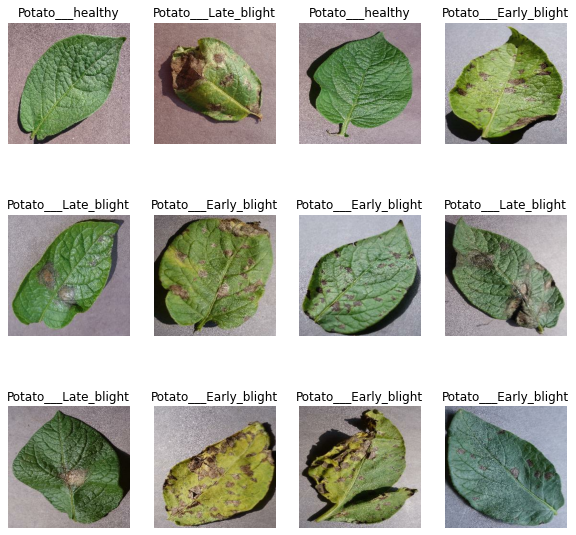

In [28]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    #Showing 12 images
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

We will set 80% data as training 
20 % == 10% as validation and 10 % as test

In [37]:
def get_datset_partitiond_tf(ds,train_split = 0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds


In [38]:
train_ds,val_ds,test_ds = get_datset_partitiond_tf(dataset)

In [41]:
# Cache read the image from disck and for next iteration it will keep the image in memory 
# So that impovrs the performance of the pipeline
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


In [44]:
resize_and_rescale = keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IAMGE_SIZE,IAMGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    ])

In [45]:
data_augmentation = keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ])